In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd

from sparse_shift.datasets import sample_cdnod_sim, sample_topological, \
    erdos_renyi_dag, connected_erdos_renyi_dag, barabasi_albert_dag
from sparse_shift.plotting import plot_dag
from sparse_shift.testing import test_mechanism_shifts, test_mechanism
from sparse_shift.methods import FullPC, PairwisePC, MinChangeOracle, MinChange
from sparse_shift.metrics import dag_tpr, dag_fpr
from sparse_shift.utils import dag2cpdag, cpdag2dags

import os
import warnings
warnings.simplefilter("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"  # Also affect subprocesses

# Experimental setup
- Fix settings:
    - intervention sparsity, sample size, 2,...,E

- Simulate DAG

- Simulate intervention targets for each env

- Simulate data from each env

- Compute CPDAG (MEC) from DAG

- Learn full pool oracle PDAG
    - Compute TP, FP edges

- Learn pairwise pool oracle PDAG
 - Compute TP, FP edges

- Learn minimal changes result
    - Compute TP, FP edges

In [35]:
SPARSITY = 1
SAMPLE_SIZE = 500
N_ENV = 5
N_NODES = 3
DENSITY = 0.5

## Sample DAG

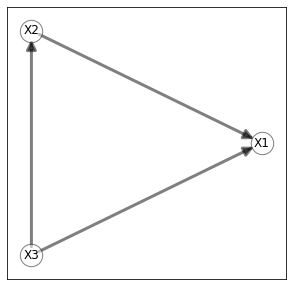

In [45]:
# Sample parent assignments
G_adj = erdos_renyi_dag(N_NODES, DENSITY, seed=4)
plot_dag(G_adj)

## Sample targets

In [46]:
# Sample targets
np.random.seed(N_ENV)
intv_targets = [np.random.choice(N_NODES, SPARSITY, replace=False) for _ in range(N_ENV)]
print(intv_targets)

[array([0]), array([2]), array([1]), array([2]), array([2])]


In [47]:
# Environment data
base_seed = 1234
Xs = [sample_cdnod_sim(
        G_adj,
        SAMPLE_SIZE,
        intervention_targets=targets,
        base_random_state=base_seed,
        domain_random_state=10*i,
    ) for i, targets in enumerate(intv_targets)]

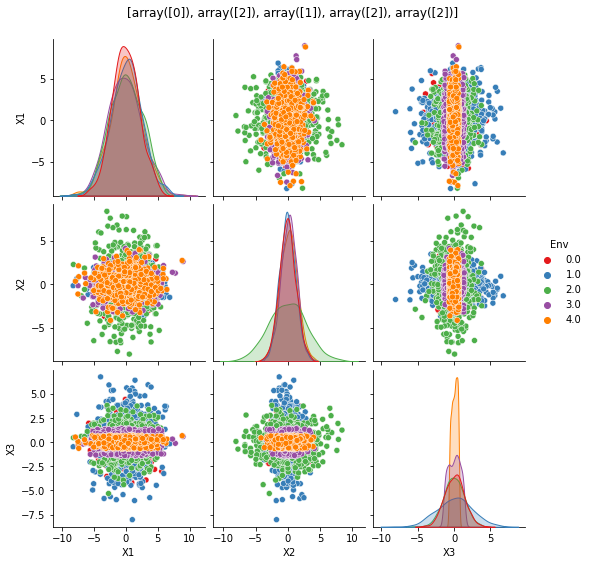

In [48]:
df = pd.DataFrame(
    np.hstack((
        np.vstack(Xs),
        np.hstack([[i]*X.shape[0] for i, X in enumerate(Xs)]).reshape(-1, 1)
    )),
    columns=[f'X{i+1}' for i in range(Xs[0].shape[1])] + ['Env']
)

sns.pairplot(df, hue='Env', palette='Set1')
plt.suptitle(intv_targets, y=1.04)
plt.show()

In [53]:
results_mat = []
dag = G_adj
cpdag = dag2cpdag(dag)

print('True DAG:')
display(dag)

mch = MinChange(
    cpdag, scale_alpha=True, alpha=0.05 / N_ENV**2, test='kci',
    test_kwargs={'KernelX': 'GaussianKernel', 'KernelY': 'GaussianKernel', 'KernelZ': 'GaussianKernel'}
)

rep = 0
        
for n_env, (true_targets, X) in enumerate(zip(intv_targets, Xs)):
    n_env += 1
    mch.add_environment(X)

    min_cpdag = mch.get_min_cpdag()
    print(mch.n_dag_changes_, true_targets)
    display(min_cpdag)
    results_mat.append([
        rep, 'Min changes (kci)', SPARSITY, n_env, len(mch.get_min_dags()),
        dag_tpr(dag, min_cpdag), dag_fpr(dag, min_cpdag)
    ])
    
df = pd.DataFrame(
    results_mat,
    columns=[
        'Rep', 'Method', 'Sparsity', 'Number of environments',
        'Number of possible DAGs', 'True positive rate', 'False positive rate'
    ])

True DAG:


array([[0, 0, 0],
       [1, 0, 0],
       [1, 1, 0]])

[0. 0. 0. 0. 0. 0.] [0]


array([[0, 1, 1],
       [1, 0, 1],
       [1, 1, 0]])

[1. 1. 1. 1. 1. 1.] [2]


array([[0, 1, 1],
       [1, 0, 1],
       [1, 1, 0]])

[4. 4. 4. 4. 4. 5.] [1]


array([[0, 1, 1],
       [1, 0, 1],
       [1, 1, 0]])

[8. 9. 9. 9. 8. 9.] [2]


array([[0, 1, 1],
       [0, 0, 1],
       [0, 1, 0]])

[13. 14. 14. 14. 13. 14.] [2]


array([[0, 1, 1],
       [0, 0, 1],
       [0, 1, 0]])

## Run Test

In [54]:
results_mat = []
dag = G_adj
cpdag = dag2cpdag(dag)

fpc = FullPC(dag)
ppc = PairwisePC(dag)
mcho = MinChangeOracle(dag)
mch = MinChange(
    cpdag, alpha=0.05, scale_alpha=True,
    test='kci',
    test_kwargs={'KernelX': 'GaussianKernel', 'KernelY': 'GaussianKernel', 'KernelZ': 'GaussianKernel'}
) #  / 3 / 6 / N_ENV**2

rep = 0
        
for n_env, (true_targets, X) in enumerate(zip(intv_targets, Xs)):
    n_env += 1
    fpc.add_environment(true_targets)
    ppc.add_environment(true_targets)
    mcho.add_environment(true_targets)
    mch.add_environment(X)
    
    cpdag = fpc.get_mec_cpdag()
    results_mat.append([
        rep, 'PC (pool all)', SPARSITY, n_env, len(fpc.get_mec_dags()), dag_tpr(dag, cpdag), dag_fpr(dag, cpdag)
    ])

    cpdag = ppc.get_mec_cpdag()
    results_mat.append([
        rep, 'PC (pool pairwise)', SPARSITY, n_env, len(ppc.get_mec_dags()), dag_tpr(dag, cpdag), dag_fpr(dag, cpdag)
    ])

    cpdag = mcho.get_min_cpdag()
    results_mat.append([
        rep, 'Min changes (oracle)', SPARSITY, n_env, len(mcho.get_min_dags()), dag_tpr(dag, cpdag), dag_fpr(dag, cpdag)
    ])
    
    cpdag = mch.get_min_cpdag()
    results_mat.append([
        rep, 'Min changes (kci)', SPARSITY, n_env, len(mch.get_min_dags()), dag_tpr(dag, cpdag), dag_fpr(dag, cpdag)
    ])
    
df = pd.DataFrame(
    results_mat,
    columns=[
        'Rep', 'Method', 'Sparsity', 'Number of environments',
        'Number of possible DAGs', 'True positive rate', 'False positive rate'
    ])

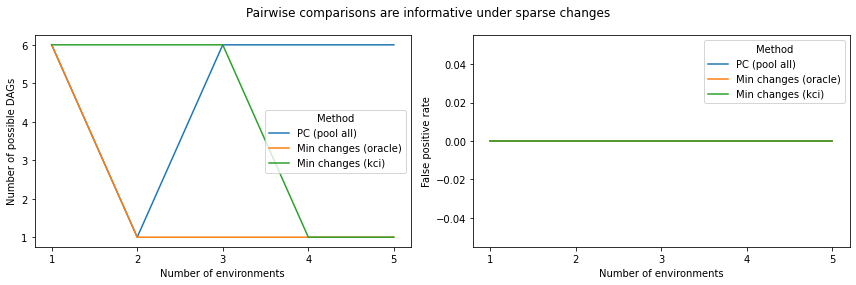

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

sns.lineplot(
    data=df[df['Method'].isin(['Min changes (oracle)', 'Min changes (kci)', 'PC (pool all)'])],
    x='Number of environments',
    # y='True positive rate',
    y='Number of possible DAGs',
    hue='Method',
    # style='Sparsity',
    ci=None,
    ax=axes[0]
)

sns.lineplot(
    data=df[df['Method'].isin(['Min changes (oracle)', 'Min changes (kci)', 'PC (pool all)'])],
    x='Number of environments',
    y='False positive rate',
    # y='Number of possible DAGs',
    hue='Method',
    # style='Sparsity',
    ci=None,
    ax=axes[1]
)

plt.suptitle('Pairwise comparisons are informative under sparse changes')
plt.tight_layout()
plt.xticks(np.arange(len(Xs)) + 1)
# plt.xscale('log')
# plt.savefig('./figures/pairwise_oracle_pc_simulation.pdf')
plt.show()

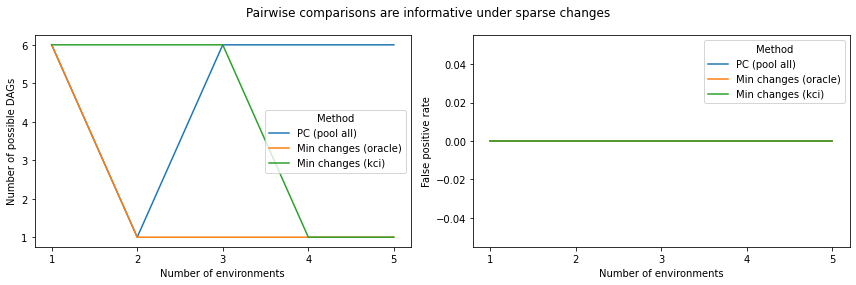

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

sns.lineplot(
    data=df[df['Method'].isin(['Min changes (oracle)', 'Min changes (kci)', 'PC (pool all)'])],
    x='Number of environments',
    # y='True positive rate',
    y='Number of possible DAGs',
    hue='Method',
    # style='Sparsity',
    ci=None,
    ax=axes[0]
)

sns.lineplot(
    data=df[df['Method'].isin(['Min changes (oracle)', 'Min changes (kci)', 'PC (pool all)'])],
    x='Number of environments',
    y='False positive rate',
    # y='Number of possible DAGs',
    hue='Method',
    # style='Sparsity',
    ci=None,
    ax=axes[1]
)

plt.suptitle('Pairwise comparisons are informative under sparse changes')
plt.tight_layout()
plt.xticks(np.arange(len(Xs)) + 1)
# plt.xscale('log')
# plt.savefig('./figures/pairwise_oracle_pc_simulation.pdf')
plt.show()

## Oracle tests

In [135]:
def compute_oracle_rates(dag, n_environments, n_reps=5, sparsities=None):
    results_mat = []
    if sparsities is None:
        sparsities = np.arange(dag.shape[0]) + 1

    for rep in range(n_reps):
        for sparsity in sparsities:
            fpc = FullPC(dag)    
            ppc = PairwisePC(dag)
            mch = MinChangeOracle(dag)

            for n_env in range(1, n_environments+1):
                interventions = np.random.choice(dag.shape[0], sparsity, replace=False)
                fpc.add_environment(interventions)
                ppc.add_environment(interventions)
                mch.add_environment(interventions)

                cpdag = fpc.get_mec_cpdag()
                results_mat.append([
                    rep, 'PC (pool all)', sparsity, n_env, len(fpc.get_mec_dags()), dag_tpr(dag, cpdag), dag_fpr(dag, cpdag)
                ])

                cpdag = ppc.get_mec_cpdag()
                results_mat.append([
                    rep, 'PC (pool pairwise)', sparsity, n_env, len(ppc.get_mec_dags()), dag_tpr(dag, cpdag), dag_fpr(dag, cpdag)
                ])

                cpdag = mch.get_cpdag()
                results_mat.append([
                    rep, 'Min changes', sparsity, n_env, len(mch.get_dags()), dag_tpr(dag, cpdag), dag_fpr(dag, cpdag)
                ])
    
    df = pd.DataFrame(
        results_mat,
        columns=[
            'Rep', 'Method', 'Sparsity', 'Number of environments',
            'Number of possible DAGs', 'True positive rate', 'False positive rate'
        ])
    return df

### Triangle

/Users/rflperry/opt/miniconda3/envs/causal/lib/python3.8/site-packages/graphical_models/custom_types.py:13: UserWarning: [Need name!] still needs to be tested. If you intend to use this method, please submit a pull request.
  warn(s)
/Users/rflperry/opt/miniconda3/envs/causal/lib/python3.8/site-packages/graphical_models/custom_types.py:13: UserWarning: dsep still needs to be tested. If you intend to use this method, please submit a pull request.
  warn(s)


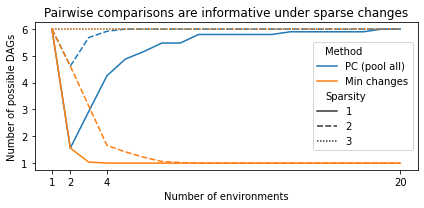

In [136]:
dag = np.asarray([[0, 0, 0], [1, 0 ,0], [1, 1, 0]]).T
df = compute_oracle_rates(dag, 20, 50)

plt.figure(figsize=(6, 3))
sns.lineplot(
    data=df[df['Method'].isin(['PC (pool all)', 'Min changes'])],
    x='Number of environments',
    # y='True positive rate',
    y='Number of possible DAGs',
    hue='Method',
    style='Sparsity',
    ci=None,
    # palette='gist_heat'
)
plt.title('Pairwise comparisons are informative under sparse changes')
plt.tight_layout()
plt.xticks([1, 2, 4, 20])
# plt.xscale('log')
plt.savefig('./figures/pairwise_oracle_pc_simulation.pdf')
plt.show()

### Sampled DAG

In [80]:
df = compute_oracle_rates(G_adj, 20, 50)

/Users/rflperry/opt/miniconda3/envs/causal/lib/python3.8/site-packages/graphical_models/custom_types.py:13: UserWarning: [Need name!] still needs to be tested. If you intend to use this method, please submit a pull request.
  warn(s)
/Users/rflperry/opt/miniconda3/envs/causal/lib/python3.8/site-packages/graphical_models/custom_types.py:13: UserWarning: dsep still needs to be tested. If you intend to use this method, please submit a pull request.
  warn(s)


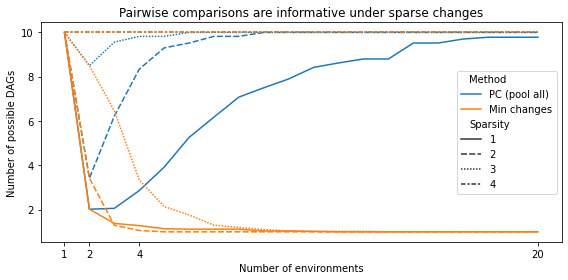

In [81]:
plt.figure(figsize=(8, 4))
sns.lineplot(
    data=df[df['Method'].isin(['PC (pool all)', 'Min changes'])],
    x='Number of environments',
    # y='True positive rate',
    y='Number of possible DAGs',
    hue='Method',
    style='Sparsity',
    ci=None,
    # palette='gist_heat'
)
plt.title('Pairwise comparisons are informative under sparse changes')
plt.tight_layout()
plt.xticks([1, 2, 4, 20])
# plt.xscale('log')
# plt.savefig('./figures/pairwise_oracle_pc_simulation.pdf')
plt.show()

### Others

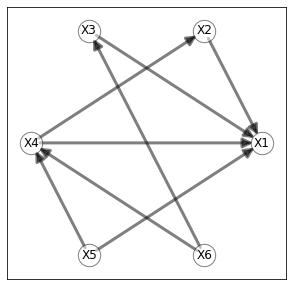

In [130]:
N_ENV = 20
N_NODES = 6
DENSITY = 0.3

# Sample parent assignments
dag = erdos_renyi_dag(N_NODES, DENSITY)
dag = barabasi_albert_dag(N_NODES, DENSITY)
plot_dag(dag)

/Users/rflperry/opt/miniconda3/envs/causal/lib/python3.8/site-packages/graphical_models/custom_types.py:13: UserWarning: [Need name!] still needs to be tested. If you intend to use this method, please submit a pull request.
  warn(s)
/Users/rflperry/opt/miniconda3/envs/causal/lib/python3.8/site-packages/graphical_models/custom_types.py:13: UserWarning: dsep still needs to be tested. If you intend to use this method, please submit a pull request.
  warn(s)


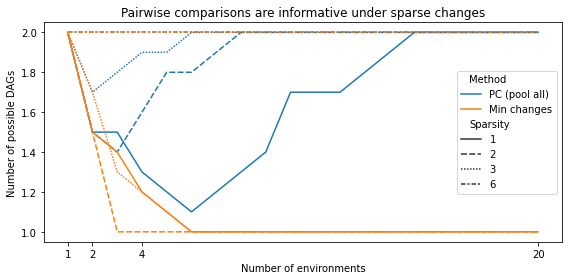

In [131]:
df = compute_oracle_rates(dag, N_ENV, 10, sparsities=[1,2,3, 6])

plt.figure(figsize=(8, 4))
sns.lineplot(
    data=df[df['Method'].isin(['PC (pool all)', 'Min changes'])],
    x='Number of environments',
    # y='True positive rate',
    y='Number of possible DAGs',
    hue='Method',
    style='Sparsity',
    ci=None,
    # palette='gist_heat'
)
plt.title('Pairwise comparisons are informative under sparse changes')
plt.tight_layout()
plt.xticks([1, 2, 4, 20])
# plt.xscale('log')
# plt.savefig('./figures/pairwise_oracle_pc_simulation.pdf')
plt.show()

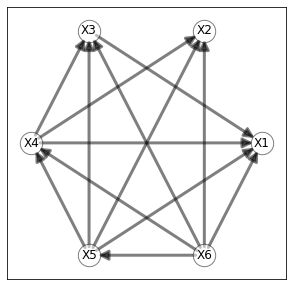

In [110]:
N_ENV = 20
N_NODES = 6
DENSITY = 0.7

# Sample parent assignments
dag = erdos_renyi_dag(N_NODES, DENSITY)
# dag = barabasi_albert_dag(N_NODES, DENSITY)
plot_dag(dag)

/Users/rflperry/opt/miniconda3/envs/causal/lib/python3.8/site-packages/graphical_models/custom_types.py:13: UserWarning: [Need name!] still needs to be tested. If you intend to use this method, please submit a pull request.
  warn(s)
/Users/rflperry/opt/miniconda3/envs/causal/lib/python3.8/site-packages/graphical_models/custom_types.py:13: UserWarning: dsep still needs to be tested. If you intend to use this method, please submit a pull request.
  warn(s)


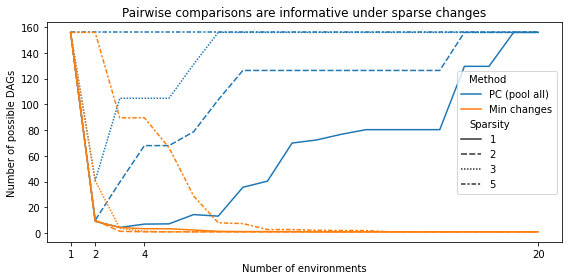

In [112]:
df = compute_oracle_rates(dag, N_ENV, 5, sparsities=[1,2,3,5])

plt.figure(figsize=(8, 4))
sns.lineplot(
    data=df[df['Method'].isin(['PC (pool all)', 'Min changes'])],
    x='Number of environments',
    # y='True positive rate',
    y='Number of possible DAGs',
    hue='Method',
    style='Sparsity',
    ci=None,
    # palette='gist_heat'
)
plt.title('Pairwise comparisons are informative under sparse changes')
plt.tight_layout()
plt.xticks([1, 2, 4, 20])
# plt.xscale('log')
# plt.savefig('./figures/pairwise_oracle_pc_simulation.pdf')
plt.show()

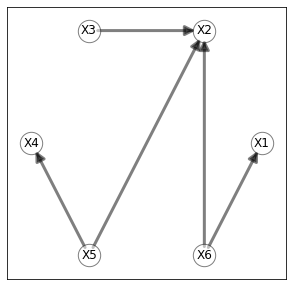

In [117]:
N_ENV = 20
N_NODES = 6
DENSITY = 0.3

# Sample parent assignments
dag = erdos_renyi_dag(N_NODES, DENSITY)
# dag = barabasi_albert_dag(N_NODES, DENSITY)
plot_dag(dag)

/Users/rflperry/opt/miniconda3/envs/causal/lib/python3.8/site-packages/graphical_models/custom_types.py:13: UserWarning: [Need name!] still needs to be tested. If you intend to use this method, please submit a pull request.
  warn(s)
/Users/rflperry/opt/miniconda3/envs/causal/lib/python3.8/site-packages/graphical_models/custom_types.py:13: UserWarning: dsep still needs to be tested. If you intend to use this method, please submit a pull request.
  warn(s)


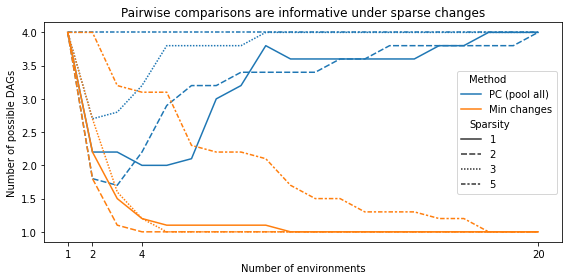

In [118]:
df = compute_oracle_rates(dag, N_ENV, 10, sparsities=[1,2,3,5])

plt.figure(figsize=(8, 4))
sns.lineplot(
    data=df[df['Method'].isin(['PC (pool all)', 'Min changes'])],
    x='Number of environments',
    # y='True positive rate',
    y='Number of possible DAGs',
    hue='Method',
    style='Sparsity',
    ci=None,
    # palette='gist_heat'
)
plt.title('Pairwise comparisons are informative under sparse changes')
plt.tight_layout()
plt.xticks([1, 2, 4, 20])
# plt.xscale('log')
# plt.savefig('./figures/pairwise_oracle_pc_simulation.pdf')
plt.show()